In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
from scipy.sparse import coo_matrix
import gc

from tqdm import tqdm

In [2]:
RUN_OUTPUT = "./data/msmarco_doc/run_psgs.trec"
QRELS = "./data/msmarco_doc/msmarco-docdev-qrels.tsv"
SEGMENT_TO_CUT = 3
CHUNK_SIZE = 10000
PRINT_TABLE = True
PRINT_LATEX = False
PRINT_PLOT = True

In [3]:
# This code is to have tqdm statistics while reading the files
run_output_file_length = sum(1 for row in open(RUN_OUTPUT, "r"))
total_run_output_chunks = (
    run_output_file_length // CHUNK_SIZE + 1
)  # Adjust for chunksize

q_rels_file_length = sum(1 for row in open(QRELS, "r"))
total_q_rels_chunks = q_rels_file_length // CHUNK_SIZE + 1  # Adjust for chunksize

In [4]:
queries_documents_pairs = []
for df in tqdm(
    pd.read_csv(QRELS, sep=" ", header=None, chunksize=CHUNK_SIZE, iterator=True),
    total=total_q_rels_chunks,
):
    df = df.rename(columns={0: "query", 2: "document"})
    df["query"] = df["query"].astype(str)
    df["query_document"] = df["query"] + "_" + df["document"]
    queries_documents_pairs.extend(df["query_document"].to_list())

    del df
    gc.collect()

100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


To run for the whole dataset utilize analysis_psg.py

In [5]:
results_for_relevant_and_unrelevant_docs = []
results_for_relevant_merging = []
i = 0
for df in tqdm(
    pd.read_csv(RUN_OUTPUT, sep=" ", header=None, chunksize=CHUNK_SIZE, iterator=True),
    total=total_run_output_chunks,
):
    df = df.rename(columns={0: "query", 2: "document_with_passage", 4: "score"})
    df[["document", "segment"]] = df["document_with_passage"].str.split(
        "@@", expand=True
    )
    df["segment"] = df["segment"].str.extract("(\d+)").astype(int) + 1
    df["query"] = df["query"].astype(str)
    df_sorted = df.sort_values(by=["document", "score"], ascending=[True, False])
    results_for_relevant_and_unrelevant_docs.extend(
        df_sorted.groupby(["query", "document"])
        .apply(lambda group: group.iloc[0]["segment"], include_groups=False)
        .tolist()
    )

    results_for_relevant_merging.extend(
        df_sorted.groupby(["query", "document"])
        .apply(
            lambda group: {
                "query_document_pair": group.name[0] + "_" + group.name[1],
                "max_segment": group.iloc[0]["segment"],
                "max_score": group.iloc[0]["score"],
                "second_segment": group.iloc[1]["segment"] if len(group) > 1 else None,
                "second_score": group.iloc[1]["score"] if len(group) > 1 else None,
                "score_difference": (
                    group.iloc[0]["score"] - group.iloc[1]["score"]
                    if len(group) > 1
                    else None
                ),
            },
            include_groups=False,
        )
        .to_list()
    )

    del df
    gc.collect()
    if i == 10:
        break
    i += 1

  0%|          | 0/5194 [00:00<?, ?it/s]

  0%|          | 10/5194 [00:23<3:22:01,  2.34s/it]


In [6]:
df_results_for_relevant_merging = pd.DataFrame(results_for_relevant_merging)
df_results_for_relevant_merging = df_results_for_relevant_merging[
    df_results_for_relevant_merging["query_document_pair"].isin(queries_documents_pairs)
]

Results for relevant and unrelevant docs
Table:
 1     23110
2     13069
3      7594
4      5000
5      3528
6      2748
7      2227
8      1758
9      1516
10     1250
11     1130
12      980
13      921
14      893
15      834
16      768
17      719
18      588
19      554
21      516
Name: count, dtype: int64


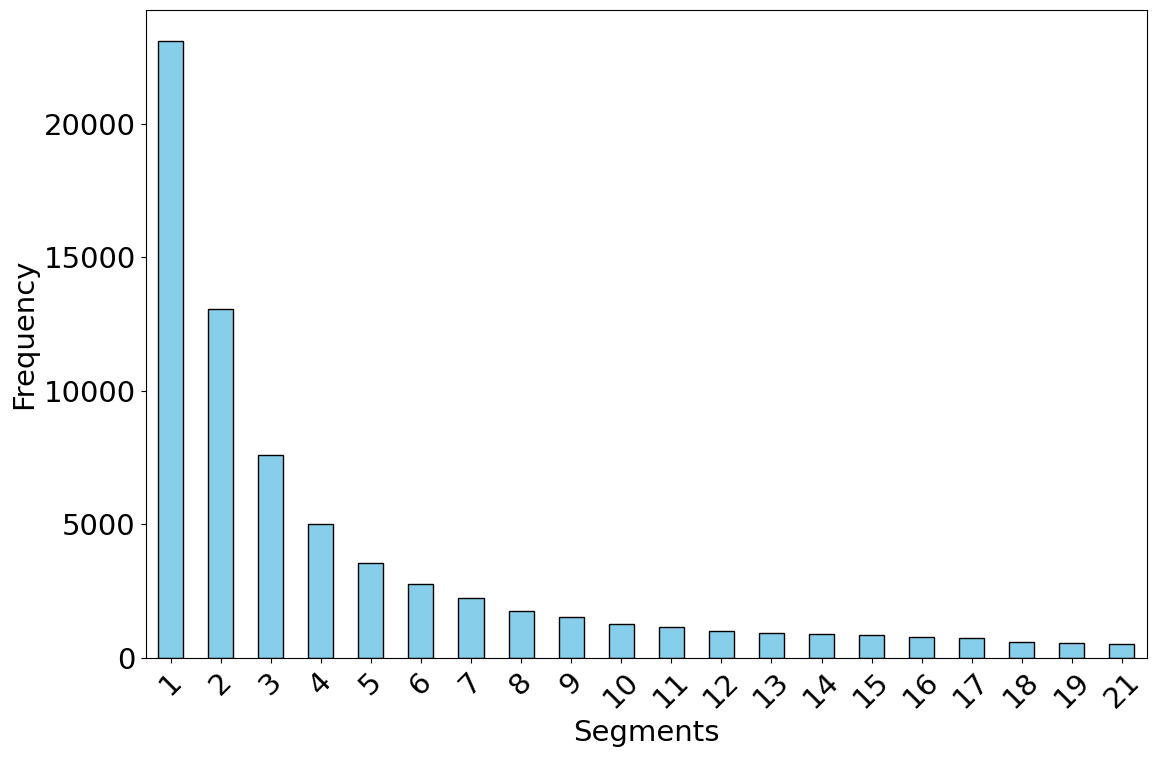

In [10]:
results = pd.Series(results_for_relevant_and_unrelevant_docs)
frequency_table = results.value_counts().head(20)
if PRINT_TABLE or PRINT_LATEX or PRINT_PLOT:
    print("Results for relevant and unrelevant docs")
if PRINT_TABLE:
    print("Table:\n", frequency_table)
if PRINT_LATEX:
    print("Latex table:\n", frequency_table.to_latex())

if PRINT_PLOT:

    plt.rcParams.update({"font.size": 21})  # Set to your desired size
    plt.figure(figsize=(12, 8))

    # Plot the frequency of score differences in a bar plot
    frequency_table.plot(kind="bar", color="skyblue", edgecolor="black")

    # Label the plot
    # plt.title("Results for relevant and unrelevant docs")
    plt.xlabel("Segments")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.savefig("./figures/analys_psg_results_for_relevant_and_unrelevant_docs")
    plt.show()

Results for relevant docs
Table:
 max_segment
1     7
8     2
24    1
3     1
Name: count, dtype: int64


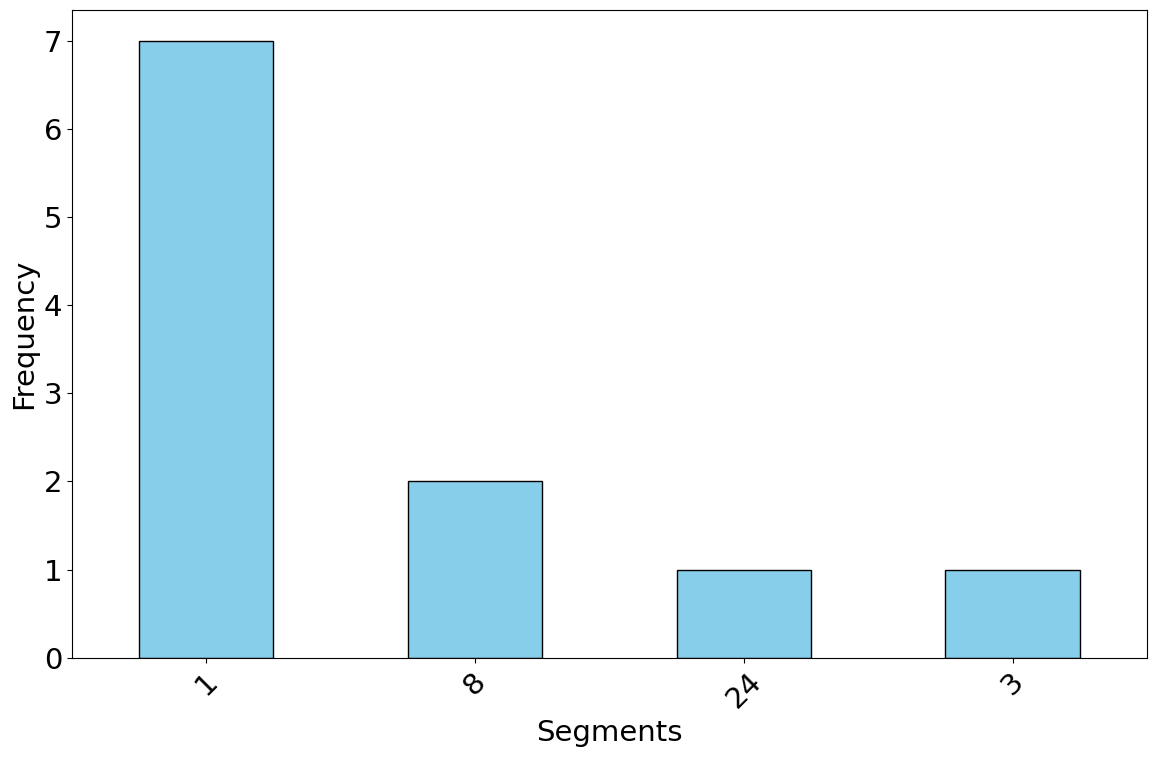

In [11]:
results = df_results_for_relevant_merging["max_segment"]
frequency_table = results.value_counts().head(20)
if PRINT_TABLE or PRINT_LATEX or PRINT_PLOT:
    print("Results for relevant docs")
if PRINT_TABLE:
    print("Table:\n", frequency_table)
if PRINT_LATEX:
    print("Latex table:\n", frequency_table.to_latex())

if PRINT_PLOT:

    plt.rcParams.update({"font.size": 21})  # Set to your desired size
    plt.figure(figsize=(12, 8))

    # Plot the frequency of score differences in a bar plot
    frequency_table.plot(kind="bar", color="skyblue", edgecolor="black")

    # Label the plot
    # plt.title("Results for relevant docs")
    plt.xlabel("Segments")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("./figures/analys_psg_results_for_relevant_docs")
    # Show the plot
    plt.show()